In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List 
import matplotlib.pyplot as plt

In [2]:
def generate_random_clusters_at(centers:List[tuple],spreads:List,num_points_per_cluster:List[int])->pd.core.frame.DataFrame:
    """
    Create random clusters on a x-y feature plane

    Args:
        centers (list[tuple]): list of tuples of center coordinate
        spreads (list): list of floating point indicating spreads
        num_points_per_cluster (list[int]): number of points in each cluster.
    """

    num_clusters=len(centers)
    points=[]
    for iind in range(num_clusters):
        point=np.random.randn(num_points_per_cluster[iind],3)
        point[:,:2]=(point[:,:2]+centers[iind])*spreads[iind]
        point[:,2]=iind+1
        points.append(point)
    points = np.concatenate(points,axis=0)
    points=pd.DataFrame(points,columns=['x','y','label'])
    points['label']=pd.Categorical(points['label'])
    return points
    

In [3]:
centers=[(7,3),(3,7),(3,3),(7,7)]
spreads=[1.8,1.5,1.1,1.3]
num_points_per_cluster=[705,3801,915,750]
points=generate_random_clusters_at(centers,spreads,num_points_per_cluster)

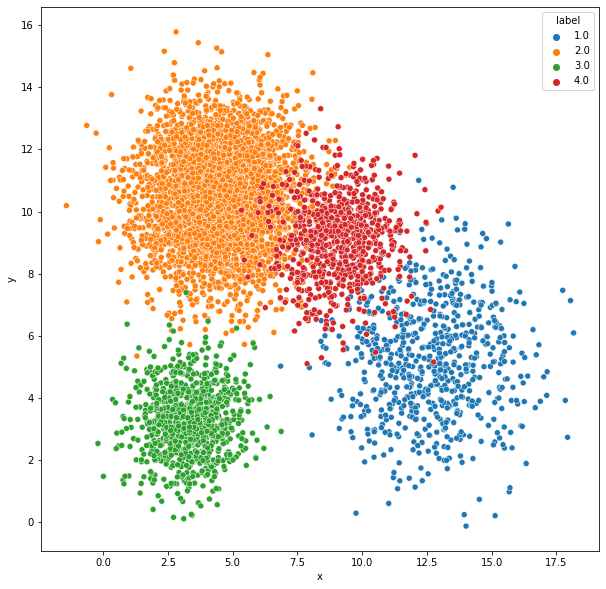

In [4]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=points,x='x',y='y',hue='label')
plt.show()
plt.close()

In [6]:
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score


In [7]:
attribute_train,attribute_test,label_train,label_test=train_test_split(points[['x','y']],points['label'],test_size=0.3)

In [8]:
xmin = np.min(points['x'])
xmax = np.max(points['x'])
ymin = np.min(points['y'])
ymax = np.max(points['y'])
h=0.1

xx,yy = np.meshgrid(np.arange(xmin,xmax,h),np.arange(ymin,ymax,h))
xx_row = xx.ravel()
yy_row = yy.ravel()

c:\Users\TEST\anaconda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
<ipython-input-9-28c0d5e2ecf2>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,zz)


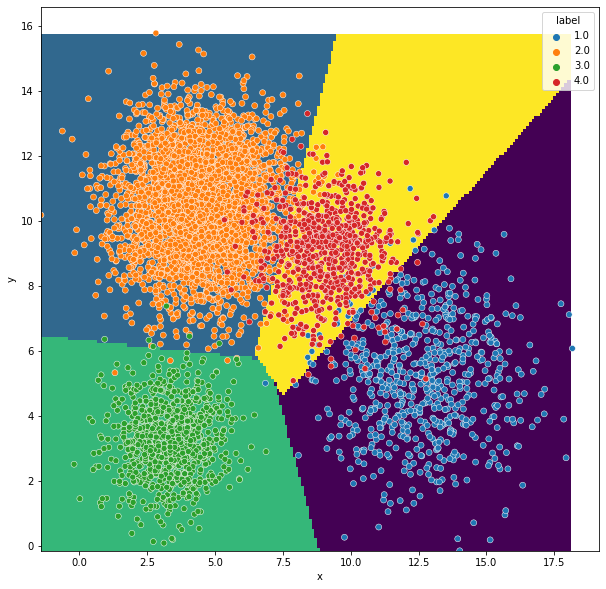

In [9]:
lcl = svm.SVC(kernel='linear')
lcl.fit(attribute_train,label_train)
zz_row=lcl.predict(np.c_[xx_row,yy_row])
zz=zz_row.reshape(xx.shape)

plt.figure(figsize=[10,10])
plt.pcolormesh(xx,yy,zz)
sns.scatterplot(data=points,x='x',y='y',hue='label')
plt.show()
plt.close()

In [10]:
attri = np.array(points[['x','y']])
label = points['label'].values.astype(int)-1
num_labels = np.unique(label).shape[0]

num_rec=attri.shape[0]
num_attri = attri.shape[1]

xmin = np.min(points['x'])
xmax = np.max(points['x'])
ymin = np.min(points['y'])
ymax = np.max(points['y'])

In [11]:
def LossFunction(data,label,weights,delta):
    num_rec = data.shape[0]
    scores = weights @ data.T 
    margins = np.maximum(0,scores-scores[label,np.arange(num_rec)]+delta)
    margins[label,np.arange(num_rec)] = 0 
    loss = np.sum(margins)/num_rec
    return loss 

In [12]:
weights = np.random.random([num_labels,num_attri])
print(LossFunction(attri,label,weights=weights,delta=1))

3.425714650044269


In [13]:
def LossFunctionGradient(data,label,weights,delta,eps=1E-3):
    
    num_rec = data.shape[0]
    scores = weights @ data.T 
    margins = np.maximum(0,scores-scores[label,np.arange(num_rec)]+delta)
    margins[label,np.arange(num_rec)] = 0 
    loss = np.sum(margins)/num_rec
    
    num_pixels = weights.shape[1]  
    num_classes = weights.shape[0]
  
    gradient = np.zeros(weights.shape)
    for jind in range(num_pixels): 
        pert = eps*data.T[jind,:]
        for iind in range(num_classes):    
            newScores = scores.copy()
            newScores[iind,:] = scores[iind,:]+pert
            newmargins = np.maximum(0,newScores-newScores[label,np.arange(num_rec)]+delta)
            newmargins[label,np.arange(num_rec)]=0
            newloss = np.sum(newmargins)/num_rec
            gradient[iind,jind]=(newloss - loss)/eps
    
    return loss,gradient

In [14]:
weights = np.random.random([num_labels,num_attri])
print(LossFunctionGradient(attri,label,weights=weights,delta=1))

(5.043958469905221, array([[-0.40683722,  3.13239251],
       [-4.46024485, -9.8890845 ],
       [ 0.16903311, -0.74899244],
       [ 4.70405317,  7.54490364]]))


In [15]:
weights = np.random.random([num_labels,num_attri])
num_steps = 2000
learning_rate = 0.1
records = []
for iind in range(num_steps):
    selected_data = np.random.randint(0,num_rec,100)
    loss,gradient=LossFunctionGradient(attri[selected_data,:],label[selected_data],weights,1)
    old_weights = weights.copy()
    
    grad_mag = np.linalg.norm(gradient)
    
    if(iind%100 == 0):
        learning_rate = learning_rate*0.5
    
    weights = weights-learning_rate*gradient/grad_mag
    
    records.append([iind+1,loss,learning_rate,grad_mag])

    # print(f'Step - {iind+1}, Loss - {loss}, Learning Rate - {learning_rate}, magnitude of gradient - {grad_mag}')
    
    if(grad_mag <1E-6):
        break

    

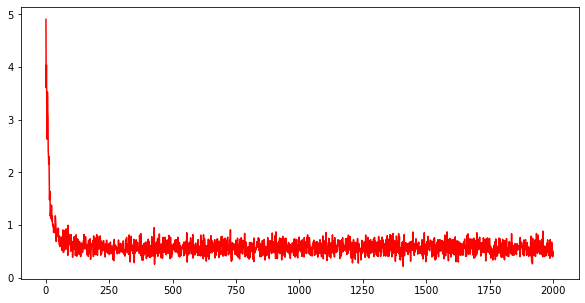

In [16]:
df=pd.DataFrame.from_records(records,columns=['Step','Loss','Learning Rate','Gradient_Magnitude'])
fig = plt.figure(figsize=[10,5])
fig.patch.set_facecolor(color="white")
plt.plot(df['Step'],df['Loss'],'-r')

In [17]:
def LossFunctionGradRegularization(data,label,weights,delta,eps=1E-3,lam=0.1):
    
    num_rec = data.shape[0]
    scores = weights @ data.T 
    margins = np.maximum(0,scores-scores[label,np.arange(num_rec)]+delta)
    margins[label,np.arange(num_rec)] = 0 
    loss = (np.sum(margins)/num_rec)
    regularization = (lam*(np.sum(weights**2)))
    
    num_pixels = weights.shape[1]  
    num_classes = weights.shape[0]
  
    gradient = np.zeros(weights.shape)
    for jind in range(num_pixels): 
        pert = eps*data.T[jind,:]
        for iind in range(num_classes):    
            newScores = scores.copy()
            newScores[iind,:] = scores[iind,:]+pert
            newmargins = np.maximum(0,newScores-newScores[label,np.arange(num_rec)]+delta)
            newmargins[label,np.arange(num_rec)]=0
            newloss = np.sum(newmargins)/num_rec
            gradient[iind,jind]=((newloss - loss)/eps)
    gradient = gradient + (2*lam*weights)
    loss = loss + regularization
    
    return loss,gradient

In [18]:
weights = np.random.random([num_labels,num_attri])
num_steps = 20000
learning_rate = 0.1
records = []
for iind in range(num_steps):
    selected_data = np.random.randint(0,num_rec,100)
    loss,gradient=LossFunctionGradRegularization(attri[selected_data,:],label[selected_data],weights,1)
    old_weights = weights.copy()
    
    grad_mag = np.linalg.norm(gradient)
    
    if(iind%1000 == 0):
        learning_rate = learning_rate*0.5
    
    weights = weights-learning_rate*gradient/grad_mag
    
    records.append([iind+1,loss,learning_rate,grad_mag])

    print(f'Step - {iind+1}, Loss - {loss}, Learning Rate - {learning_rate}, magnitude of gradient - {grad_mag}')
    
    if(grad_mag <1E-6):
        break

Step - 1, Loss - 8.335074649643202, Learning Rate - 0.05, magnitude of gradient - 16.57548099244236
Step - 2, Loss - 6.354662754364303, Learning Rate - 0.05, magnitude of gradient - 16.59689031097553
Step - 3, Loss - 7.96024599927214, Learning Rate - 0.05, magnitude of gradient - 12.799362189488443
Step - 4, Loss - 6.519063796563803, Learning Rate - 0.05, magnitude of gradient - 12.205463138264465
Step - 5, Loss - 5.397138777758637, Learning Rate - 0.05, magnitude of gradient - 12.863969028732813
Step - 6, Loss - 5.196431376597787, Learning Rate - 0.05, magnitude of gradient - 11.42057323485167
Step - 7, Loss - 4.988184005835479, Learning Rate - 0.05, magnitude of gradient - 11.276594728246117
Step - 8, Loss - 5.165980648996545, Learning Rate - 0.05, magnitude of gradient - 12.620870804072553
Step - 9, Loss - 4.200078118094768, Learning Rate - 0.05, magnitude of gradient - 8.848242069330794
Step - 10, Loss - 3.3233572006571226, Learning Rate - 0.05, magnitude of gradient - 5.8435253811

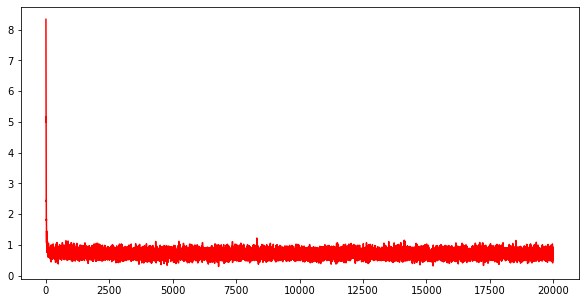

In [19]:
df=pd.DataFrame.from_records(records,columns=['Step','Loss','Learning Rate','Gradient_Magnitude'])
fig = plt.figure(figsize=[10,5])
fig.patch.set_facecolor(color="white")
plt.plot(df['Step'],df['Loss'],'-r')

In [20]:
def prediction(weights,attri):
    p_score = weights @ attri
    labels=np.argmax(p_score,axis=0)
    return labels
    

<ipython-input-21-b3182f9d1011>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,zz)


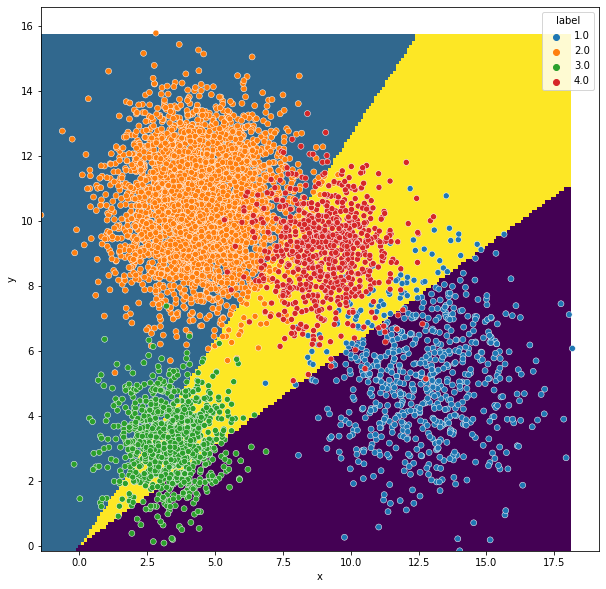

In [21]:
attrib = np.c_[xx_row,yy_row].T
zz_row=prediction(weights,attrib)
zz=zz_row.reshape(xx.shape)
plt.figure(figsize=[10,10])
plt.pcolormesh(xx,yy,zz)
sns.scatterplot(data=points,x='x',y='y',hue='label')
plt.show()
plt.close()

In [22]:
def LossFunctionGradientWithBias(data,label,weights,bias,delta,eps=1E-3):
    
    num_rec = data.shape[0]
    scores = weights @ data.T + np.c_[bias]
    margins = np.maximum(0,scores-scores[label,np.arange(num_rec)]+delta)
    margins[label,np.arange(num_rec)] = 0 
    loss = np.sum(margins)/num_rec
    
    num_pixels = weights.shape[1]  
    num_classes = weights.shape[0]
  
    wgradient = np.zeros(weights.shape)
    for jind in range(num_pixels): 
        pert = eps*data.T[jind,:]
        for iind in range(num_classes):    
            newScores = scores.copy()
            newScores[iind,:] = scores[iind,:]+pert
            newmargins = np.maximum(0,newScores-newScores[label,np.arange(num_rec)]+delta)
            newmargins[label,np.arange(num_rec)]=0
            newloss = np.sum(newmargins)/num_rec
            wgradient[iind,jind]=(newloss - loss)/eps
    
    pert=eps
    bgradient = np.zeros(bias.shape)
    for iind in range(num_classes):
        newScores = scores.copy()
        newScores[iind] = newScores[iind]+eps
        newmargins = np.maximum(0,newScores-newScores[label,np.arange(num_rec)]+delta)
        newmargins[label,np.arange(num_rec)]=0
        newloss = np.sum(newmargins)/num_rec
        bgradient[iind] = (newloss - loss)/eps
        
    return loss,wgradient,bgradient

In [23]:
weights = np.random.random([num_labels,num_attri])
bias = np.random.random(num_labels)
num_steps = 2000
learning_rate = 0.3
records = []

for iind in range(num_steps):

    selected_data = np.random.randint(0,num_rec,100)
    loss,wgradient,bgradient=LossFunctionGradientWithBias(attri[selected_data,:],label[selected_data],weights,bias,1)
    
    old_weights = weights.copy()
    old_bias = bias.copy()
    
    wgrad_mag = np.linalg.norm(wgradient)
    bgrad_mag = np.linalg.norm(bgradient)
    
    if(iind%1000 == 0):
        learning_rate = learning_rate*0.5
    
    weights = weights-learning_rate*wgradient/wgrad_mag
    bias = bias - learning_rate*bgradient/bgrad_mag
    
    records.append([iind+1,loss,learning_rate,wgrad_mag,bgrad_mag])

    print(f'Step - {iind+1}, Loss - {loss}, Learning Rate - {learning_rate}, magnitude of gradient of weights - {wgrad_mag}, magnitude of gradient of bias - {bgrad_mag}')
    
    if(wgrad_mag <1E-1 or bgrad_mag<1E-1):
        break

Step - 1, Loss - 8.620019402146516, Learning Rate - 0.15, magnitude of gradient of weights - 24.688023236396074, magnitude of gradient of bias - 2.1145685139051897
Step - 2, Loss - 5.645775117631704, Learning Rate - 0.15, magnitude of gradient of weights - 18.444813350515894, magnitude of gradient of bias - 1.6899704139421592
Step - 3, Loss - 3.106410801155795, Learning Rate - 0.15, magnitude of gradient of weights - 7.771329359396958, magnitude of gradient of bias - 0.8105553651665761
Step - 4, Loss - 2.261648213602218, Learning Rate - 0.15, magnitude of gradient of weights - 5.691743869220668, magnitude of gradient of bias - 0.7270678796190377
Step - 5, Loss - 1.6755406022304384, Learning Rate - 0.15, magnitude of gradient of weights - 3.838865561523271, magnitude of gradient of bias - 0.5446099521674862
Step - 6, Loss - 1.0761337306824532, Learning Rate - 0.15, magnitude of gradient of weights - 7.845703197969972, magnitude of gradient of bias - 0.7736924453550553
Step - 7, Loss - 1

In [24]:
def prediction(weights,bias,attri):
    p_score = weights @ attri + np.c_[bias]
    labels=np.argmax(p_score,axis=0)
    return labels

<ipython-input-25-9c163a1ee01c>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,zz)


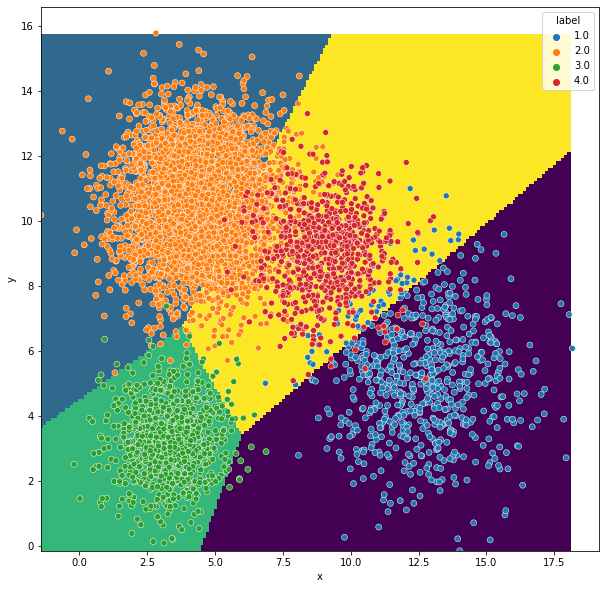

In [25]:
attrib = np.c_[xx_row,yy_row].T
zz_row=prediction(weights,bias,attrib)
zz=zz_row.reshape(xx.shape)
plt.figure(figsize=[10,10])
plt.pcolormesh(xx,yy,zz)
sns.scatterplot(data=points,x='x',y='y',hue='label')
plt.show()
plt.close()